In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-bom0payl
All libraries are successfully installed!


## Enabling Import of Custom Python Modules from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9')

In [0]:
from torch.utils.data import DataLoader, Dataset

In [0]:
from albumentations import *
from albumentations.pytorch import ToTensor
import data_preprocess_Albumentation_module_1
import resnet
import train_test_module_CrossEntropy
import gradcam_module

In [0]:
from __future__ import print_function
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensor

### Using GPU instead of CPU

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_preprocess_Albumentation_module_1.albumentation_train())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_preprocess_Albumentation_module_1.albumentation_test())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



In [0]:
trainloader, testloader = data_preprocess_Albumentation_module_1.get_train_test_loader(trainset, testset)

plane   dog  deer  deer


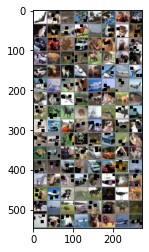

In [10]:
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
images.shape

torch.Size([128, 3, 32, 32])

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [12]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.ResNet18().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [13]:
def test():
    net = resnet.ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
test()

torch.Size([1, 10])


In [23]:
from torch.optim.lr_scheduler import StepLR

net =  resnet.ResNet18().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

EPOCHS = 30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test_module_CrossEntropy.train(net, device, trainloader, optimizer, epoch)
    scheduler.step()
    train_test_module_CrossEntropy.test(net, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.055476188659668 Batch_id=390 Accuracy=41.33: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.2325, Accuracy: 5232/10000 (52.32%)

EPOCH: 1


Loss=1.0921218395233154 Batch_id=390 Accuracy=60.64: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.4275, Accuracy: 6722/10000 (67.22%)

EPOCH: 2


Loss=0.8434870839118958 Batch_id=390 Accuracy=70.13: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.1325, Accuracy: 7034/10000 (70.34%)

EPOCH: 3


Loss=0.7534888982772827 Batch_id=390 Accuracy=75.44: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.3778, Accuracy: 7605/10000 (76.05%)

EPOCH: 4


Loss=0.7875413298606873 Batch_id=390 Accuracy=78.77: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0707, Accuracy: 7929/10000 (79.29%)

EPOCH: 5


Loss=0.6609033942222595 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7686, Accuracy: 7889/10000 (78.89%)

EPOCH: 6


Loss=0.5519313812255859 Batch_id=390 Accuracy=82.56: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2566, Accuracy: 8306/10000 (83.06%)

EPOCH: 7


Loss=0.4703810214996338 Batch_id=390 Accuracy=84.14: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.8568, Accuracy: 8103/10000 (81.03%)

EPOCH: 8


Loss=0.525279700756073 Batch_id=390 Accuracy=85.41: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8537, Accuracy: 8151/10000 (81.51%)

EPOCH: 9


Loss=0.3162211775779724 Batch_id=390 Accuracy=86.37: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8401, Accuracy: 8170/10000 (81.70%)

EPOCH: 10


Loss=0.2837648391723633 Batch_id=390 Accuracy=90.67: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.7424, Accuracy: 8630/10000 (86.30%)

EPOCH: 11


Loss=0.3148995041847229 Batch_id=390 Accuracy=91.79: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.9738, Accuracy: 8705/10000 (87.05%)

EPOCH: 12


Loss=0.22619764506816864 Batch_id=390 Accuracy=92.38: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.8060, Accuracy: 8790/10000 (87.90%)

EPOCH: 13


Loss=0.2208402156829834 Batch_id=390 Accuracy=92.69: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.9733, Accuracy: 8701/10000 (87.01%)

EPOCH: 14


Loss=0.2376837283372879 Batch_id=390 Accuracy=92.99: 100%|██████████| 391/391 [00:30<00:00, 12.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.1365, Accuracy: 8553/10000 (85.53%)

EPOCH: 15


Loss=0.23935151100158691 Batch_id=390 Accuracy=93.39: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.2199, Accuracy: 8465/10000 (84.65%)

EPOCH: 16


Loss=0.17560097575187683 Batch_id=390 Accuracy=93.50: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.9927, Accuracy: 8639/10000 (86.39%)

EPOCH: 17


Loss=0.15032848715782166 Batch_id=390 Accuracy=93.78: 100%|██████████| 391/391 [00:30<00:00, 12.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.8974, Accuracy: 8583/10000 (85.83%)

EPOCH: 18


Loss=0.3161270320415497 Batch_id=390 Accuracy=93.88: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.0666, Accuracy: 8673/10000 (86.73%)

EPOCH: 19


Loss=0.19473955035209656 Batch_id=390 Accuracy=94.06: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.1811, Accuracy: 8608/10000 (86.08%)

EPOCH: 20


Loss=0.12824593484401703 Batch_id=390 Accuracy=96.82: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.6868, Accuracy: 8999/10000 (89.99%)

EPOCH: 21


Loss=0.09348060190677643 Batch_id=390 Accuracy=97.52: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8221, Accuracy: 8980/10000 (89.80%)

EPOCH: 22


Loss=0.14728407561779022 Batch_id=390 Accuracy=97.95: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8680, Accuracy: 9016/10000 (90.16%)

EPOCH: 23


Loss=0.03514387458562851 Batch_id=390 Accuracy=97.86: 100%|██████████| 391/391 [00:30<00:00, 12.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.7740, Accuracy: 8959/10000 (89.59%)

EPOCH: 24


Loss=0.06846953928470612 Batch_id=390 Accuracy=97.84: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8165, Accuracy: 8959/10000 (89.59%)

EPOCH: 25


Loss=0.03432213142514229 Batch_id=390 Accuracy=97.82: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8153, Accuracy: 8940/10000 (89.40%)

EPOCH: 26


Loss=0.07825308293104172 Batch_id=390 Accuracy=97.82: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8669, Accuracy: 8951/10000 (89.51%)

EPOCH: 27


Loss=0.039526939392089844 Batch_id=390 Accuracy=97.86: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.7750, Accuracy: 8809/10000 (88.09%)

EPOCH: 28


Loss=0.08523408323526382 Batch_id=390 Accuracy=97.89: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.7987, Accuracy: 8974/10000 (89.74%)

EPOCH: 29


Loss=0.10989208519458771 Batch_id=390 Accuracy=97.55: 100%|██████████| 391/391 [00:30<00:00, 12.85it/s]



Test set: Average loss: -9.5082, Accuracy: 8835/10000 (88.35%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


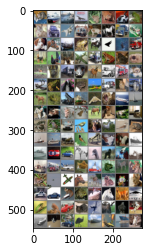

In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [26]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 73 %
Accuracy of  deer : 92 %
Accuracy of   dog : 84 %
Accuracy of  frog : 86 %
Accuracy of horse : 88 %
Accuracy of  ship : 90 %
Accuracy of truck : 84 %


## GradCam 

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradcam_module.VisualizeCam(net,classes, target_layers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


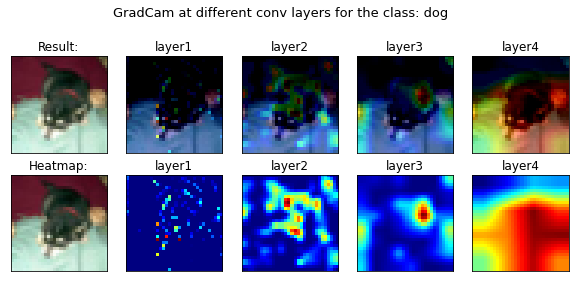

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


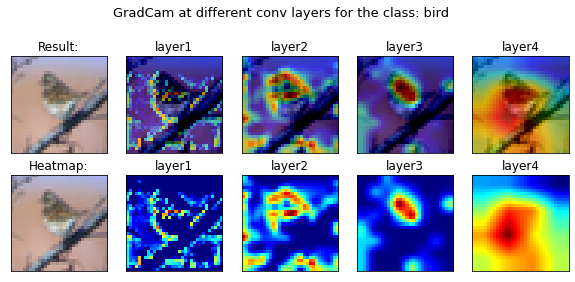

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


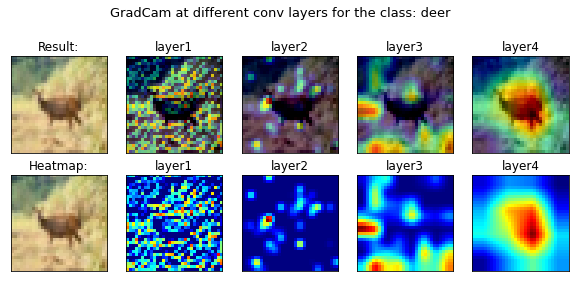

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


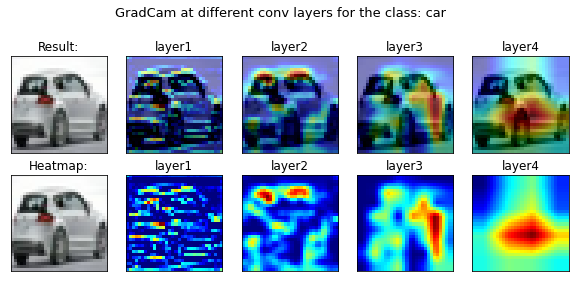

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


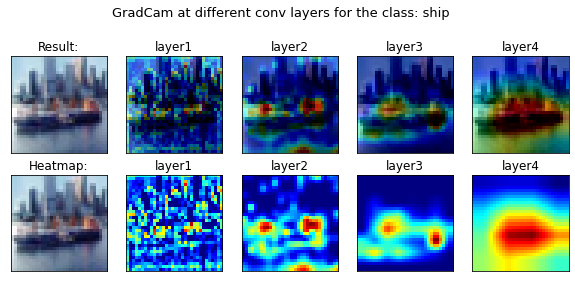

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


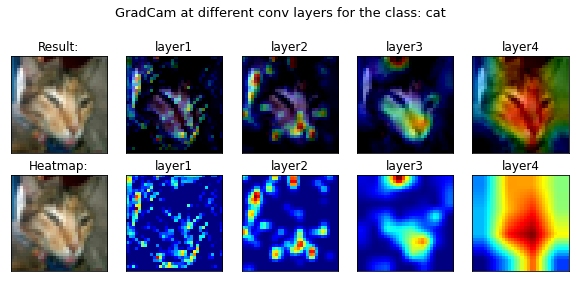

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


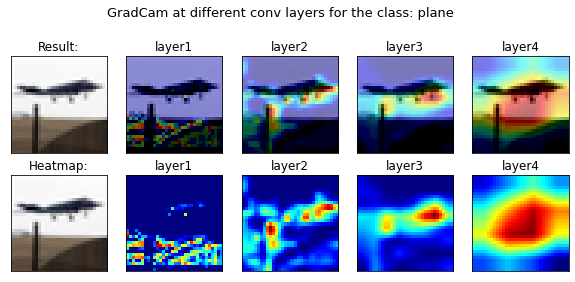

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


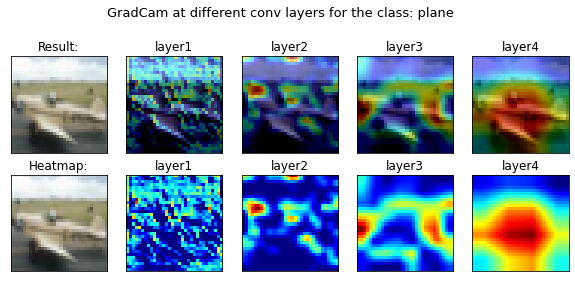

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


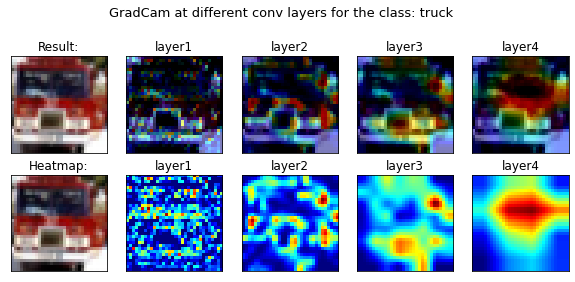

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


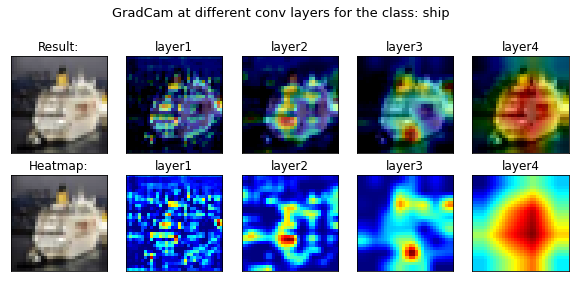

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


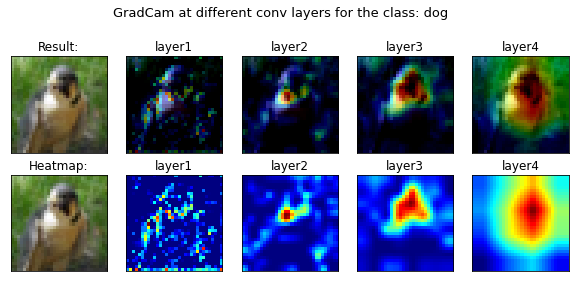

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


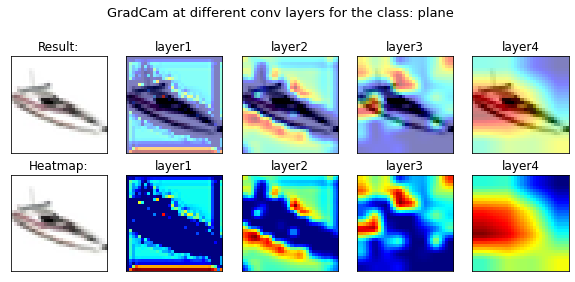

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


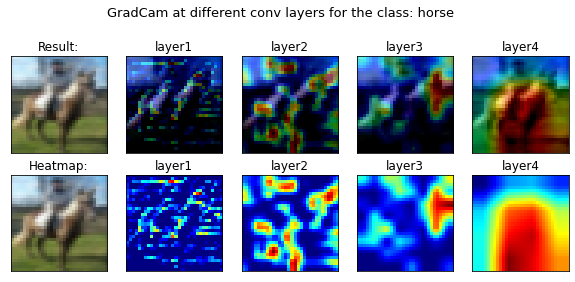

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


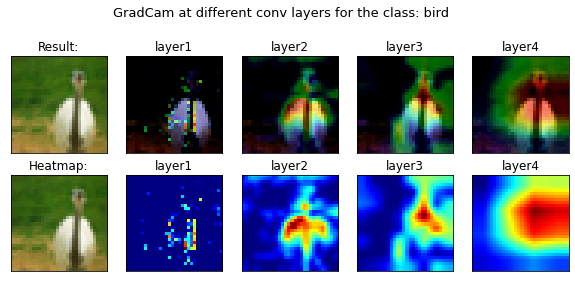

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


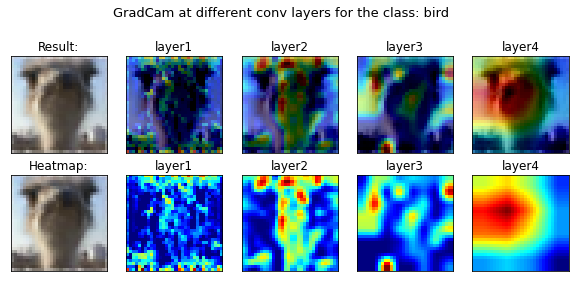

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


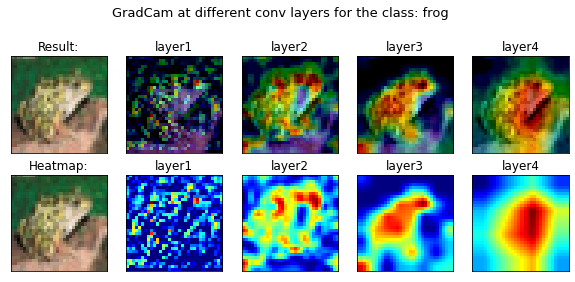

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


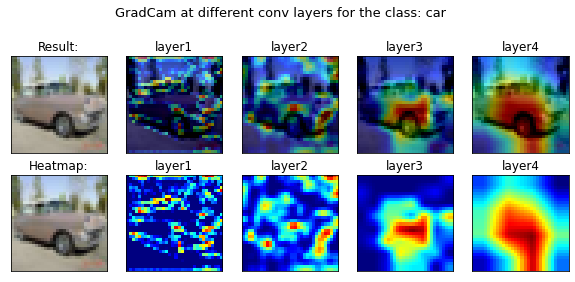

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


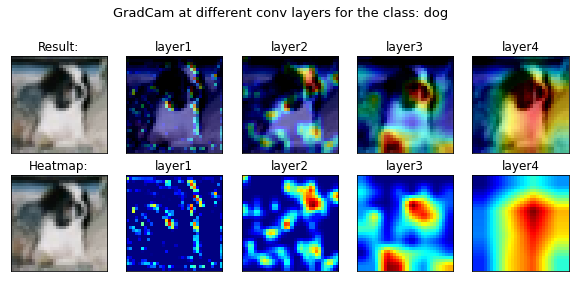

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


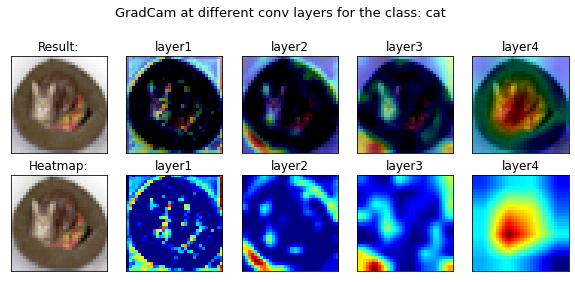

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


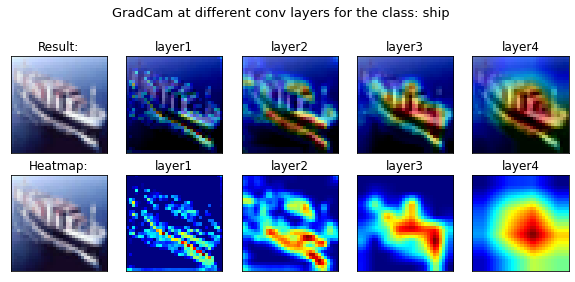

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


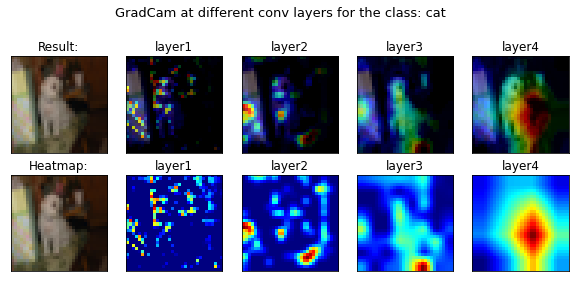

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


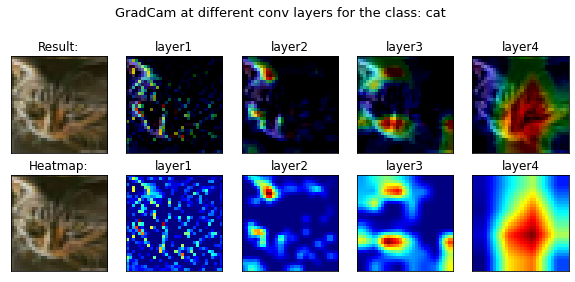

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


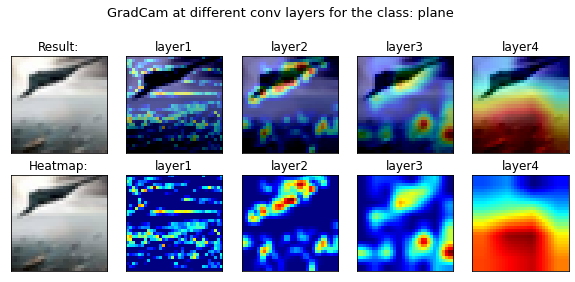

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


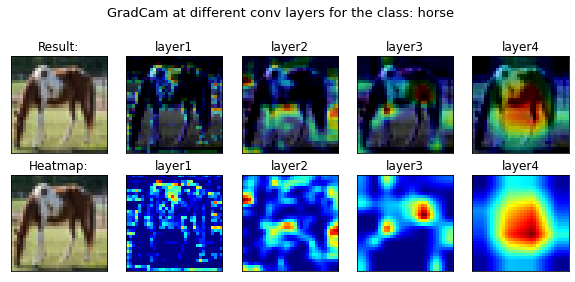

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


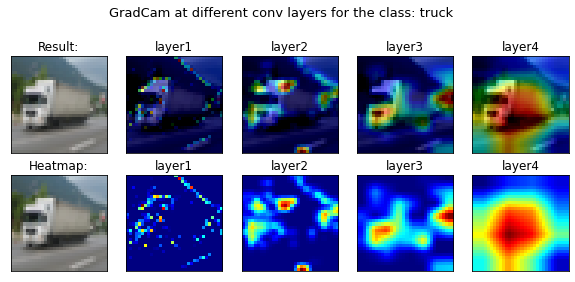

In [30]:
correct_pred_imgs = []
dataiter = iter(testloader)
images, labels = dataiter.next()
for i in range(5):
  images, labels = dataiter.next()
  viz_cam( images, target_layers)